# Detección de Anomalías con Autoencoder

## Problema a resolver

Detectar la presencia (sujeto *anormal*) o ausencia (sujeto *normal*) de irregularidades en el ritmo cardíaco, a partir de señales de electrocardiograma (ECG).

¿Estas métricas son normales?



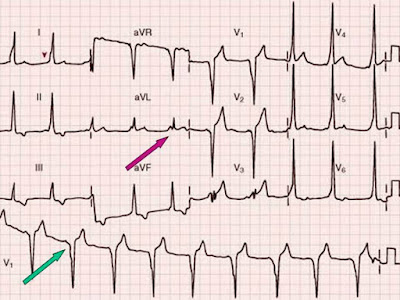

**Pre-excitación ventricular. PR corto (flecha lila), QRS ancho y onda delta (flecha verde).** [Ref](https://cardiologiadeportiva.blogspot.com/2017/04/hallazgos-anormales-en-ecg-atletas-ii.html)

El problema es que usualmente se cuenta con sets de datos **desbalanceados**, es decir, con más datos normales que anormales. Esto se vincula directamente con la naturaleza de este tipo de datos. Ya vimos qué pasa si se intenta entrenar modelos con grandes desbalances.

## Set de datos

Se usará el set [ECG5000](https://timeseriesclassification.com/description.php?Dataset=ECG5000) con 7600 datos de entrenamiento y 1900 de prueba.

Cada dato contiene un ciclo cardiaco con 140 muestras, y que puede pertenecer a una de 5 categorías:

1. Normal
2. Anormal: contracción ventricular prematura
3. Anormal: contracción supra-ventricular prematura
4. Anormal: latido ectópico
5. Anormal: patología desconocida

El problema del set ECG5000 es que contiene 4427 datos normales y 3173 anormales, es decir está desbalanceado.

De hecho para ciertas categorías anormales (3 y 5) se tienen muy pocos datos:

| Categoría   | Nro. datos |
|-------------|------------|
| 1 (normal)  | 4427       |
| 2 (anormal) | 2683       |
| 3 (anormal) | 149        |
| 4 (anormal) | 306        |
| 5 (anormal) | 35         |

Encarar un modelo de clasificació normal... produciría un error muy grande para las clases minoritarias. En un conexto médico, justamente estas clases son las que interesan detectar.

In [ ]:
# Datos del repositorio oficial
# !wget https://timeseriesclassification.com/Downloads/ECG5000.zip
# Están en un formato horrible, los tengo parseados :)

# Datos parseados desde el repositorio del curso
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1i7XEYUcjC3siv8qEXt9WtpZyBB1QZqtq&confirm=t" -O ECG5000_to_csv.zip

!unzip -qq ECG5000_to_csv.zip

--2023-10-05 13:21:34--  https://drive.google.com/uc?export=download&id=1i7XEYUcjC3siv8qEXt9WtpZyBB1QZqtq&confirm=t
Resolving drive.google.com (drive.google.com)... 64.233.181.102, 64.233.181.101, 64.233.181.100, ...
Connecting to drive.google.com (drive.google.com)|64.233.181.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mkpif1vst151l6o80q9mml6giucjp11m/1696512075000/12225850433951268217/*/1i7XEYUcjC3siv8qEXt9WtpZyBB1QZqtq?e=download&uuid=5e656265-1464-4940-ba99-62b0159148a4 [following]
--2023-10-05 13:21:36--  https://doc-08-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mkpif1vst151l6o80q9mml6giucjp11m/1696512075000/12225850433951268217/*/1i7XEYUcjC3siv8qEXt9WtpZyBB1QZqtq?e=download&uuid=5e656265-1464-4940-ba99-62b0159148a4
Resolving doc-08-9c-docs.googleusercontent.com (doc-08-9c-docs.googleusercontent.com)... 173.194.74.

In [ ]:
import pandas as pd
df_train = pd.read_csv('ECG5000_TRAIN.csv')
df_test = pd.read_csv('ECG5000_TEST.csv')

# La primer columna: "Categoria" tiene mapeada la categoría de la muestra
# Coincidente con la tabla de la descripción del dataset

In [ ]:
df_train

,Categoria,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,-1.30300,-0.83573,-1.93360,-2.09420,-2.02840,-1.2531,-0.52638,-0.089286,-0.07557,...,-1.45820,-1.6676,-1.59770,-1.67930,-1.677200,-1.69370,-1.79410,-1.35940,-2.081200,-2.82880
1,2,0.32288,-0.87847,-1.80230,-2.66850,-3.26550,-3.3326,-2.88000,-2.227400,-1.54360,...,-1.23050,-1.7218,-2.19530,-2.74890,-3.446500,-3.66210,-3.01820,-1.65140,-0.236700,0.82832
2,2,1.39340,1.59260,1.24200,0.79449,0.19577,-0.3156,-0.58053,-0.945020,-1.23350,...,-1.90850,-2.5295,-3.06140,-3.50370,-3.900400,-4.24600,-4.13380,-3.19850,-2.422000,-1.07370
3,1,-3.52270,-5.02610,-4.36130,-4.10570,-3.10420,-1.8178,-1.39840,-1.070100,-0.40691,...,0.83038,1.0084,1.18300,0.94636,0.952130,0.79343,0.84741,1.01390,0.312340,-2.19060
4,1,-1.91820,-3.22510,-3.46520,-4.00800,-3.87030,-3.3581,-2.28540,-1.728500,-1.42220,...,1.77690,1.5029,1.16510,0.46073,0.019172,-0.32739,-0.48051,-0.18814,0.142840,-0.66844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,1,-1.16070,-2.59870,-2.94830,-3.55150,-3.95150,-3.7986,-3.07710,-1.978600,-1.51320,...,1.65530,1.2486,0.82331,0.17421,-0.487430,-1.03590,-1.27420,-1.29160,-0.696480,-0.99869
7596,1,0.32296,-0.63839,-1.88670,-3.37590,-4.14790,-4.2007,-3.75540,-3.062700,-1.80550,...,1.42910,1.3295,0.58693,-0.42123,-1.155200,-1.36600,-1.32360,-0.59262,-0.072396,-1.38680
7597,2,-0.54602,-1.43010,-1.90640,-2.58710,-2.85140,-2.8966,-2.79470,-2.452400,-2.12310,...,-1.73600,-2.1648,-2.56710,-2.99770,-3.216300,-3.21620,-2.70910,-1.79670,-1.000800,0.28521
7598,2,-0.81539,-1.28880,-1.48070,-1.77510,-1.98290,-2.1216,-2.17600,-2.098600,-1.87270,...,-1.96960,-2.5253,-3.20130,-3.83790,-4.014100,-3.61140,-2.73260,-1.75620,-1.262500,-0.61828


In [ ]:
# Cantidad de observaciones por archivos
print(df_train.shape)
print(df_test.shape)

(7600, 141)
(1900, 141)


In [ ]:
# Observaciones por categoría (para entrenamiento)
df_train['Categoria'].value_counts()

1    4427
2    2683
4     306
3     149
5      35
Name: Categoria, dtype: int64

In [ ]:
# Observaciones por categoría (para test)
df_test['Categoria'].value_counts()

1    1119
2     674
4      63
3      33
5      11
Name: Categoria, dtype: int64

## Autoencoder y detección de anomalías

El autoencoder se entrenará **únicamente con datos normales**. Así, al reconstruir un dato anormal **el error será alto**.

**Topología Típica:**

---



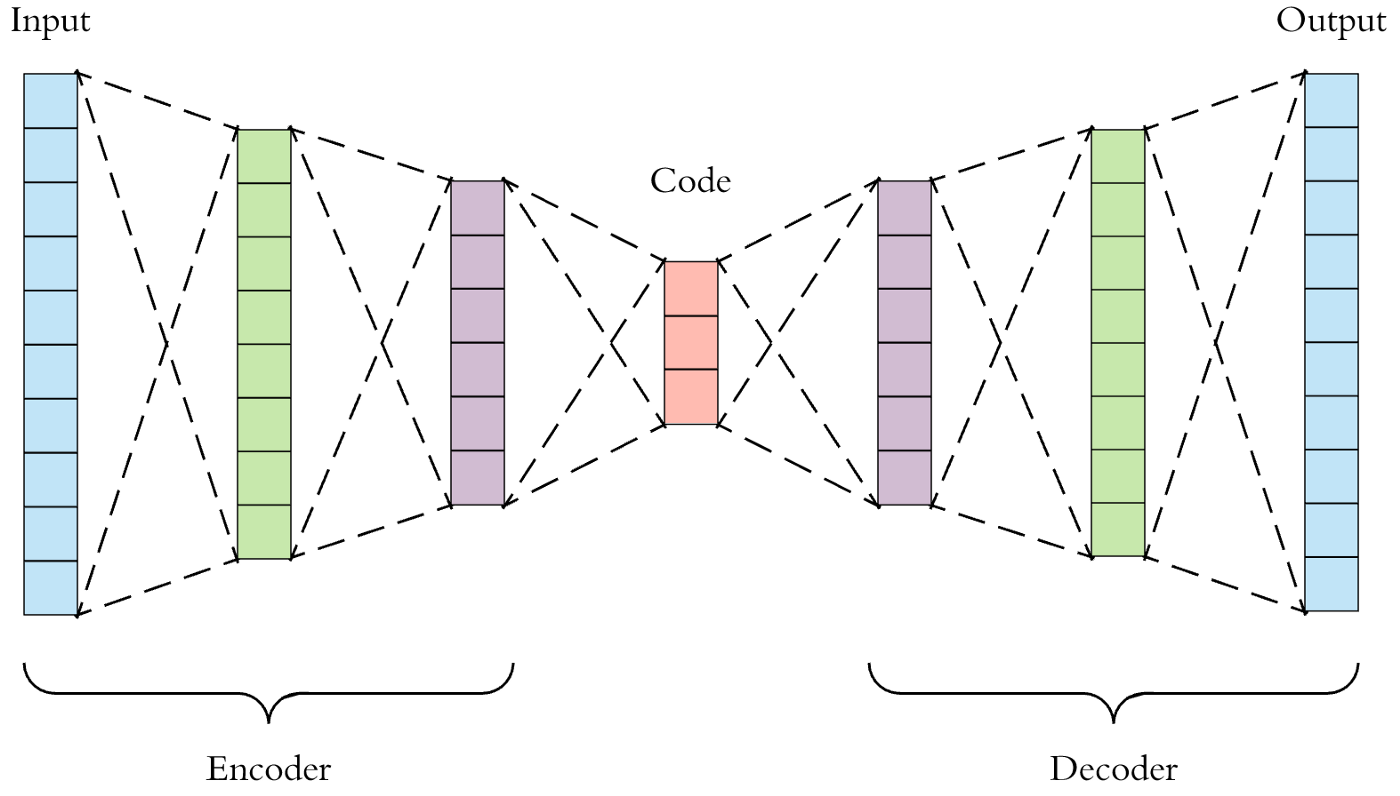

[Ref.](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798)

Los autoencoders siguen una arquitectura de cuello de botella, la región encoder está formada por una o varias capas, cada una con menos neuronas que su capa precedente, obligando así a que la información de entrada se vaya comprimiendo. En la región decoder esta compresión se revierte siguiendo la misma estructura pero esta vez de menos a más neuronas.

Para conseguir que la salida reconstruida sea lo más parecida posible a la entrada, el modelo debe aprender a capturar toda la información posible en la zona intermedia. Una vez entrenado, la salida de la capa central del autoencoder (la capa con menos neuronas) es una representación de los datos de entrada pero con una dimensionalidad igual el número de neuronas de esta capa.

La **principal ventaja de los autoencoders** es que no tienen ninguna restricción en cuanto al tipo de relaciones que pueden aprender, por lo tanto, a diferencia del PCA, **la reducción de dimensionalidad puede incluir relaciones no lineales**. La desventaja es su alto riesgo de sobreentrenamiento (overfitting), por lo que se recomienda emplear muy pocas épocas y siempre evaluar la evolución del error con un conjunto de validación.

En el caso de utilizar funciones de activación lineales, las variables generadas en el cuello de botella (la capa con menos neuronas), son muy similares a las componentes principales de un PCA pero sin que necesariamente tengan que ser ortogonales entre ellas.

### Sets de entrenamiento y validación

In [ ]:
# Pandas a arreglos numpy
datos_train = df_train.values
datos_test = df_test.values

# Etiquetas, me quedo solamente con el vector de las categorías
cat_train = datos_train[:,0]
cat_test = datos_test[:,0]

# Subdivisión por categorías, aplico un filtro para separar las muestras. Se quita el primero, porque es la categoría.
x_train_1 = datos_train[cat_train==1,1:]    # Corresponde a la Categoría 1 del set de entrenamiento
x_train_2 = datos_train[cat_train==2,1:]
x_train_3 = datos_train[cat_train==3,1:]
x_train_4 = datos_train[cat_train==4,1:]
x_train_5 = datos_train[cat_train==5,1:]

x_test_1 = datos_test[cat_test==1,1:]
x_test_2 = datos_test[cat_test==2,1:]
x_test_3 = datos_test[cat_test==3,1:]
x_test_4 = datos_test[cat_test==4,1:]
x_test_5 = datos_test[cat_test==5,1:]       # Corresponde a la Categoría 5 del set de testing

In [ ]:
x_train_1.shape

(4427, 140)

### Comparación visual entre las clases

<ipython-input-9-fc4690dfdd76>:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


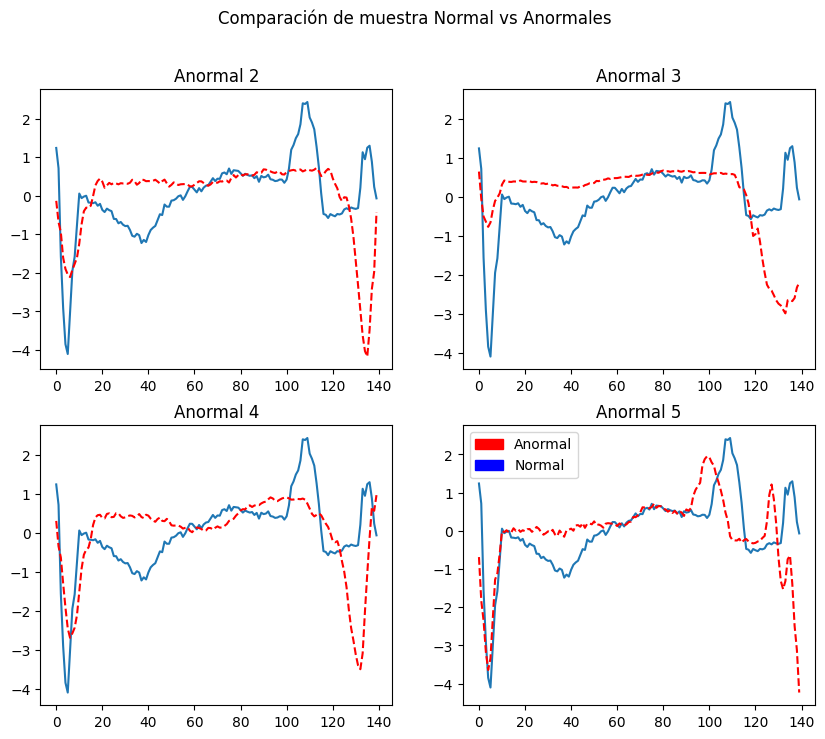

In [ ]:
# Dibujar un dato normal y uno de cada anormal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

muestra = 3     # Elegir número de muestra. Cómo mucho puede ser el máximo del conjunto más pequeño.
normal = x_train_1[muestra]
anormal_2 = x_train_2[muestra]
anormal_3 = x_train_3[muestra]
anormal_4 = x_train_4[muestra]
anormal_5 = x_train_5[muestra]


red = mpatches.Patch(color='red', label='Anormal')
blue = mpatches.Patch(color='blue', label='Normal')
plt.figure(figsize=(10,8))
plt.grid()
plt.subplot(2,2,1)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_2, 'r--')
plt.title('Anormal 2')
plt.subplot(2,2,2)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_3, 'r--')
plt.title('Anormal 3')
plt.subplot(2,2,3)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_4, 'r--')
plt.title('Anormal 4')
plt.subplot(2,2,4)
plt.plot(np.arange(140), normal)
plt.plot(np.arange(140), anormal_5, 'r--')
plt.title('Anormal 5')
plt.legend(handles=[red, blue])
plt.suptitle('Comparación de muestra Normal vs Anormales')
plt.show()

### Preprocesamiento (normalización de los datos)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

x_train_1_s = min_max_scaler.fit_transform(x_train_1)
print('Mínimo y máximo originales: {:.1f}, {:.1f}'.format(np.min(x_train_1), np.max(x_train_1)))
print('Mínimo y máximo normalización: {:.1f}, {:.1f}'.format(np.min(x_train_1_s), np.max(x_train_1_s)))

x_test_1_s = min_max_scaler.transform(x_test_1)
x_test_2_s = min_max_scaler.transform(x_test_2)
x_test_3_s = min_max_scaler.transform(x_test_3)
x_test_4_s = min_max_scaler.transform(x_test_4)
x_test_5_s = min_max_scaler.transform(x_test_5)

Mínimo y máximo originales: -7.1, 5.0
Mínimo y máximo normalización: 0.0, 1.0


### Creación del Autoencoder

In [ ]:
from tensorflow.keras.models import Model           # Para construir el modelo con las capas especificadas
from tensorflow.keras.layers import Input, Dense    # Tipos de capas a utilizar
import tensorflow as tf

np.random.seed(123) # Para replicar resultados
tf.random.set_seed(111)

dim_entrada = x_train_1_s.shape[1]    # 140 muestras/ejemplo
entrada = Input(shape=(dim_entrada,))                               # Capa de entrada, tamaño de las muestras

# Encoder
encoder = Dense(32, activation='relu')(entrada)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(8, activation='relu')(encoder)                      # Cuello, punto de simetría

# Decoder
decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(dim_entrada, activation='sigmoid')(decoder)         # Capa de salida, tamaño de las muestras

# Autoencoder = entrada + decoder (que ya contiene el encoder)
autoencoder = Model(inputs=entrada, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 dense (Dense)               (None, 32)                4512      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 140)               4620  

### Optimización y entrenamiento


In [ ]:
x_train_1_s.shape

(4427, 140)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')       # error absoluto medio (*Mean Absolute Error*, MAE), función de pérdida
historia = autoencoder.fit(x_train_1_s, x_train_1_s,    # Notar que para entrenar, la entrada y salida son similares. Se evalúa la reconstrucción.
          epochs=20,
          batch_size=512,
          validation_data=(x_test_1_s, x_test_1_s),
          shuffle=True)

Epoch 1/20
9/9 [==============================] - 4s 49ms/step - loss: 0.1258 - val_loss: 0.1232
Epoch 2/20
9/9 [==============================] - 0s 16ms/step - loss: 0.1199 - val_loss: 0.1148
Epoch 3/20
9/9 [==============================] - 0s 16ms/step - loss: 0.1097 - val_loss: 0.1030
Epoch 4/20
9/9 [==============================] - 0s 15ms/step - loss: 0.0977 - val_loss: 0.0908
Epoch 5/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0861 - val_loss: 0.0805
Epoch 6/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0770 - val_loss: 0.0733
Epoch 7/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0711 - val_loss: 0.0691
Epoch 8/20
9/9 [==============================] - 0s 14ms/step - loss: 0.0679 - val_loss: 0.0670
Epoch 9/20
9/9 [==============================] - 0s 13ms/step - loss: 0.0663 - val_loss: 0.0658
Epoch 10/20
9/9 [==============================] - 0s 15ms/step - loss: 0.0652 - val_loss: 0.0650
Epoch 11/20
9/9 [============

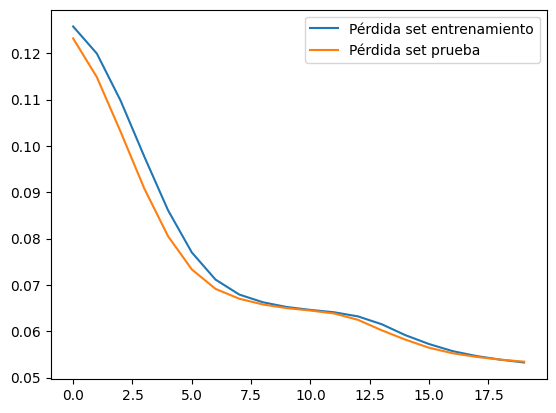

In [ ]:
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["val_loss"], label="Pérdida set prueba")
plt.legend()

## Clasificación

Text(0.5, 1.0, 'Clase Anormal')

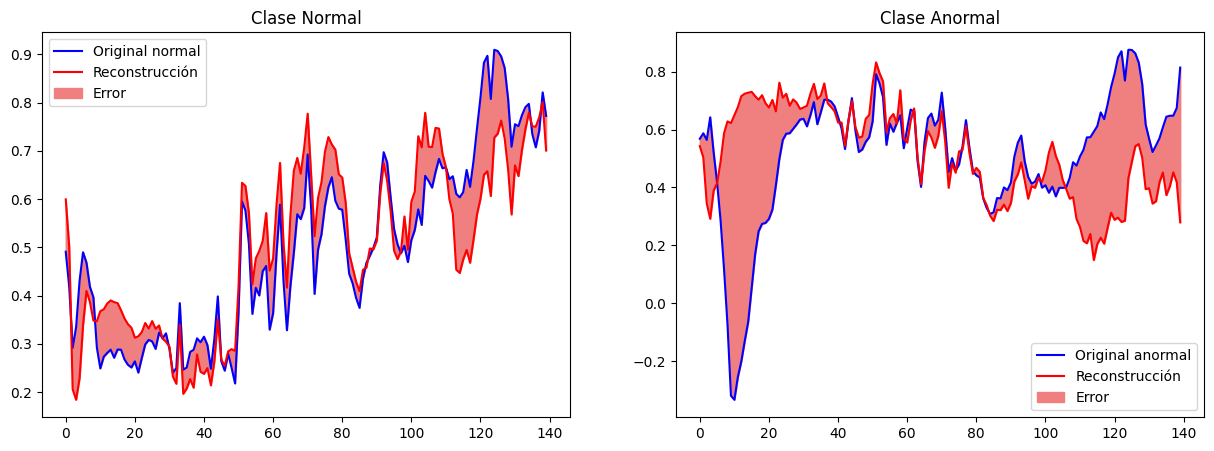

In [ ]:
# ¿Qué tan bien reconstruye un dato "normal" y uno anormal?
rec_normal = autoencoder(x_test_1_s).numpy()
rec_anormal = autoencoder(x_test_2_s).numpy()

dato = 5
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x_test_1_s[dato],'b')
plt.plot(rec_normal[dato],'r')
plt.fill_between(np.arange(140), rec_normal[dato], x_test_1_s[dato], color='lightcoral')    # Este método rellena el área de diferencia entre funciones. El error en este caso.
plt.legend(labels=["Original normal", "Reconstrucción", "Error"])
plt.title("Clase Normal")
plt.subplot(1,2,2)
plt.plot(x_test_5_s[dato],'b')
plt.plot(rec_anormal[dato],'r')
plt.fill_between(np.arange(140), rec_anormal[dato], x_test_5_s[dato], color='lightcoral')
plt.legend(labels=["Original anormal", "Reconstrucción", "Error"])
plt.title("Clase Anormal")

Se observa a simple vista que el error es mayor a la hora de reconstruir una clase anormal. Con esta diferencia, se pueden construir un histograma y determinar el umbral óptimo para la separación de las clases.

In [ ]:
# Distribuciones de los errores de construcción
# para cada categoría

rec_1 = autoencoder.predict(x_test_1_s)
rec_2 = autoencoder.predict(x_test_2_s)
rec_3 = autoencoder.predict(x_test_3_s)
rec_4 = autoencoder.predict(x_test_4_s)
rec_5 = autoencoder.predict(x_test_5_s)

loss_1 = tf.keras.losses.mae(rec_1, x_test_1_s) # Calcula la media de la diferencia absoluta entre etiquetas y predicciones. Lo de los errores.
loss_2 = tf.keras.losses.mae(rec_2, x_test_2_s)
loss_3 = tf.keras.losses.mae(rec_3, x_test_3_s)
loss_4 = tf.keras.losses.mae(rec_4, x_test_4_s)
loss_5 = tf.keras.losses.mae(rec_5, x_test_5_s)

1/1 [==============================] - 0s 23ms/step


In [ ]:
# Cálculo del umbral óptimo para la separación
umbral = np.mean(loss_1) + np.std(loss_1)       # Media de la pérdida más el desvío estándar en este caso.
print("Umbral: ", umbral)

# Es decir, establecemos un valor de umbral tal que el dato anómalo debe tener una desviación estándar por encima de la media.

Umbral:  0.08071560640028806


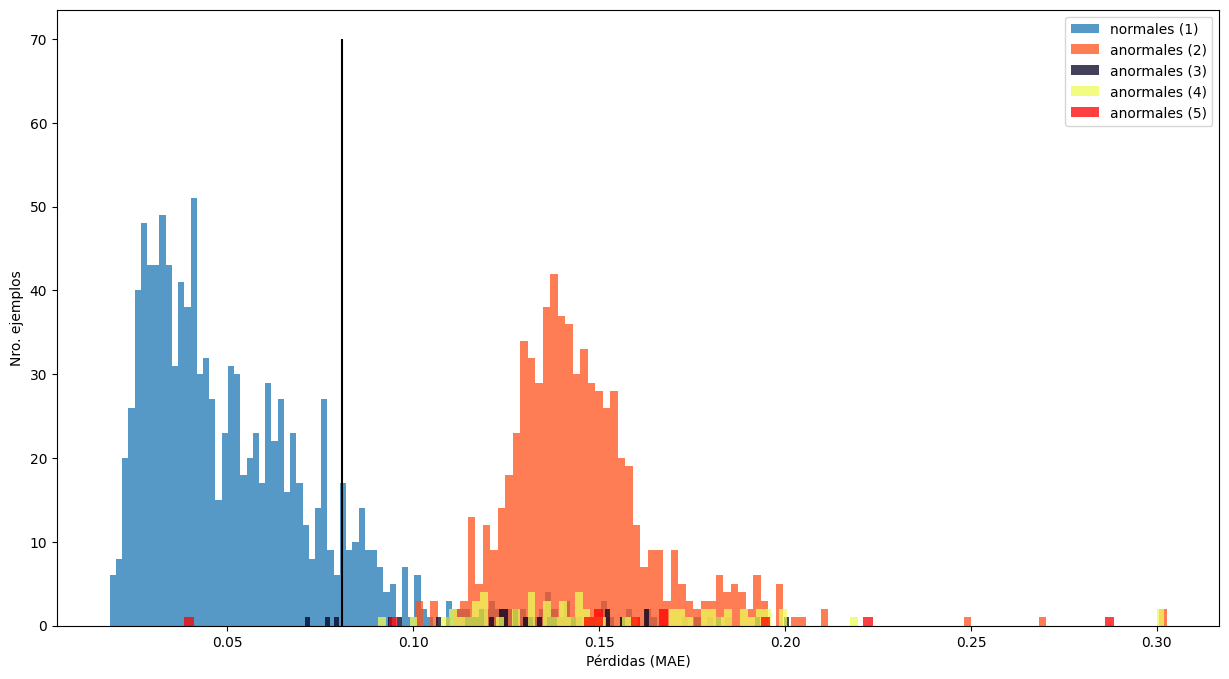

In [ ]:
# Gráficas de las distribuciones por categorías, más umbral de separación
plt.figure(figsize=(15,8))
plt.hist(loss_1[None,:], bins=100, alpha=0.75, label='normales (1)')
plt.hist(loss_2[None,:], bins=100, alpha=0.75, color='#ff521b', label='anormales (2)')
plt.hist(loss_3[None,:], bins=100, alpha=0.75, color='#020122', label='anormales (3)')
plt.hist(loss_4[None,:], bins=100, alpha=0.75, color='#eefc57', label='anormales (4)')
plt.hist(loss_5[None,:], bins=100, alpha=0.75, color='r', label='anormales (5)')
plt.xlabel('Pérdidas (MAE)')
plt.ylabel('Nro. ejemplos')
plt.legend(loc='upper right')
plt.vlines(umbral,0,70,'k')


Puedo establecer un umbral en base a estos datos y sus distribuciones. A ojímetro, según el tipo de aplicación y la clase que me interesa detectar a toda costa, con el análisis de las distribuciones y el desvío, etc.

Con el umbral definido... a la hora de **hacer inferencia**, simplemente se calcula la pérdida entre la clase de la entrada y la predicha por la red. Por sobre el umbral será anomalía, y por debajo normal.

### Sensitividad y especificidad

- Verdaderos positivos (TP): anormales que han sido correctamente clasificados como anormales
- Falsos negativos (FN): anormales que han sido clasificados erróneamente como normales
- Verdaderos negativos (TN): normales que han sido correctamente clasificados como normales
- Falsos positivos (FP): normales que han sido clasificados erróneamente como anormales

La **sensitividad** mide la proporción de anormales que fueron detectados correctamente como anormales. Una sensitividad del 100% detectará a todos los pacientes enfermos:

$sensitividad = \frac{TP}{TP+FN}$

La **especificidad** mide la proporción de normales que fueron detectados correctamente como normales. Una especificidad del 100% detectará a todos los pacientes sanos:

$especificidad = \frac{TN}{TN+FP}$

In [ ]:
# Función ejemplo de inferencia en producción utilizando el modelo. Asumimos que llegan normalizados los datos.
def predecir(modelo, datos, umbral):
  reconstrucciones = modelo(datos)
  perdida = tf.keras.losses.mae(reconstrucciones, datos)
  return tf.math.less(perdida, umbral)

# Cálculo de las métricas recién vistas.
def calcular_sensitividad(prediccion, titulo):
  TP = np.count_nonzero(~prediccion)
  FN = np.count_nonzero(prediccion)
  sen = 100*(TP/(TP+FN))

  print(titulo + ': {:.2f}%'.format(sen))

def calcular_especificidad(prediccion, titulo):
  TN = np.count_nonzero(prediccion)
  FP = np.count_nonzero(~prediccion)
  esp = 100*(TN/(TN+FP))

  print(titulo + ': {:.2f}%'.format(esp))
  return esp

In [ ]:
# Predicciones
pred_1 = predecir(autoencoder, x_test_1_s, umbral)
pred_2 = predecir(autoencoder, x_test_2_s, umbral)
pred_3 = predecir(autoencoder, x_test_3_s, umbral)
pred_4 = predecir(autoencoder, x_test_4_s, umbral)
pred_5 = predecir(autoencoder, x_test_5_s, umbral)

# Pred 1: Especificidad
esp_1 = calcular_especificidad(pred_1,'Especificidad (cat. 1, normales)')

# Pred 2 a 5: Sensitividad
sen_2 = calcular_sensitividad(pred_2,'Sensitividad (cat. 2, anormales)')
sen_3 = calcular_sensitividad(pred_3,'Sensitividad (cat. 3, anormales)')
sen_4 = calcular_sensitividad(pred_4,'Sensitividad (cat. 4, anormales)')
sen_5 = calcular_sensitividad(pred_3,'Sensitividad (cat. 5, anormales)')

Especificidad (cat. 1, normales): 86.60%
Sensitividad (cat. 2, anormales): 100.00%
Sensitividad (cat. 3, anormales): 90.91%
Sensitividad (cat. 4, anormales): 100.00%
Sensitividad (cat. 5, anormales): 90.91%


### Métricas Usuales

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

def metricas_generales(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
# Para procesar todas las entradas en dataset de test
datos_test_s = datos_test[:,1:]                         # Agarro todo desde la columna uno en adelante, saco la categoría
datos_test_s = min_max_scaler.transform(datos_test_s)   # Escalado usado en preprocesamiento
cat_test_binario = np.array([i==1 for i in cat_test])   # Mapeo de cateorías, 1 es True y el resto es False (anómalas)


predicciones = predecir(autoencoder, datos_test_s, umbral)
metricas_generales(predicciones, cat_test_binario)

Accuracy = 0.9189473684210526
Precision = 0.9958890030832477
Recall = 0.8659517426273459


In [ ]:
print("Classification Report: \n", classification_report(cat_test_binario, predicciones))

Classification Report: 
               precision    recall  f1-score   support

       False       0.84      0.99      0.91       781
        True       1.00      0.87      0.93      1119

    accuracy                           0.92      1900
   macro avg       0.92      0.93      0.92      1900
weighted avg       0.93      0.92      0.92      1900



## Plus: Extractor de Características

### Recorte del modelo entrenado

In [ ]:
encoder_entrenado = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-4].output)  # Nos quedamos únicamente con la parte del encoder, hasta el cuello

In [ ]:
encoder_entrenado.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 dense (Dense)               (None, 32)                4512      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 5176 (20.22 KB)
Trainable params: 5176 (20.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Preparación de los datos

In [ ]:
datos_train_s = datos_train[:,1:]                         # Agarro todo desde la columna uno en adelante, saco la categoría
datos_train_s = min_max_scaler.transform(datos_train_s)   # Escalado usado en preprocesamiento
cat_train_binario = np.array([i==1 for i in cat_train])   # True para clase Normal, false para Anormal

In [ ]:
# Tamaño original de los datos para entrenamiento
datos_train_s.shape     # Vector de 140 muestras por observación

(7600, 140)

In [ ]:
new_features = encoder_entrenado(datos_train_s)           # Obtención de la salida del encoder

In [ ]:
# Nuevo tamaño, reducción dimensional considerable. Vector de características de las señales de interés, descriptores.
new_features.shape       # Ahora, Vector de 8 muestras por observación 8)

TensorShape([7600, 8])

In [ ]:
new_features_test = encoder_entrenado(datos_test_s)      # Misma transformación para los datos de testing

### Modelo simple de clasificación

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(new_features, cat_train_binario)     # Entrenamiento con las 8 características determinadas por el encoder

pred_lr = lr_clf.predict(new_features_test)     # Validación contra los datos para testing

In [ ]:
# Resultados, directamenta comparables a los del autoencoder
print("Classification Report: \n", classification_report(cat_test_binario, pred_lr))

# Mejora considerable para la detección de las anomalías, antes era 85%, ahora 95%!

Classification Report: 
               precision    recall  f1-score   support

       False       0.89      0.93      0.91       781
        True       0.95      0.92      0.94      1119

    accuracy                           0.93      1900
   macro avg       0.92      0.93      0.92      1900
weighted avg       0.93      0.93      0.93      1900



### Vistazo a las características

In [ ]:
df_codif = pd.DataFrame(new_features.numpy())

In [ ]:
df_codif
# Pareciera que algunas columnas tienen solamente 0, el modelo convergió a descartar algunas características

,0,1,2,3,4,5,6,7
0,1.574151,0.000000,0.205442,2.289497,0.399787,0.0,0.0,0.0
1,0.094440,0.000000,1.537664,1.623051,0.995020,0.0,0.0,0.0
2,0.912720,0.000000,0.721704,2.101917,0.636540,0.0,0.0,0.0
3,0.000000,0.162955,1.901417,1.268816,1.086063,0.0,0.0,0.0
4,0.000000,0.424750,2.101614,0.989207,1.059593,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7595,0.000000,0.147023,1.850630,1.346171,1.128524,0.0,0.0,0.0
7596,0.000000,0.103080,1.763788,1.351791,1.069888,0.0,0.0,0.0
7597,0.303626,0.000000,1.228957,1.931773,0.945795,0.0,0.0,0.0
7598,0.428835,0.000000,1.139452,2.056787,0.915358,0.0,0.0,0.0


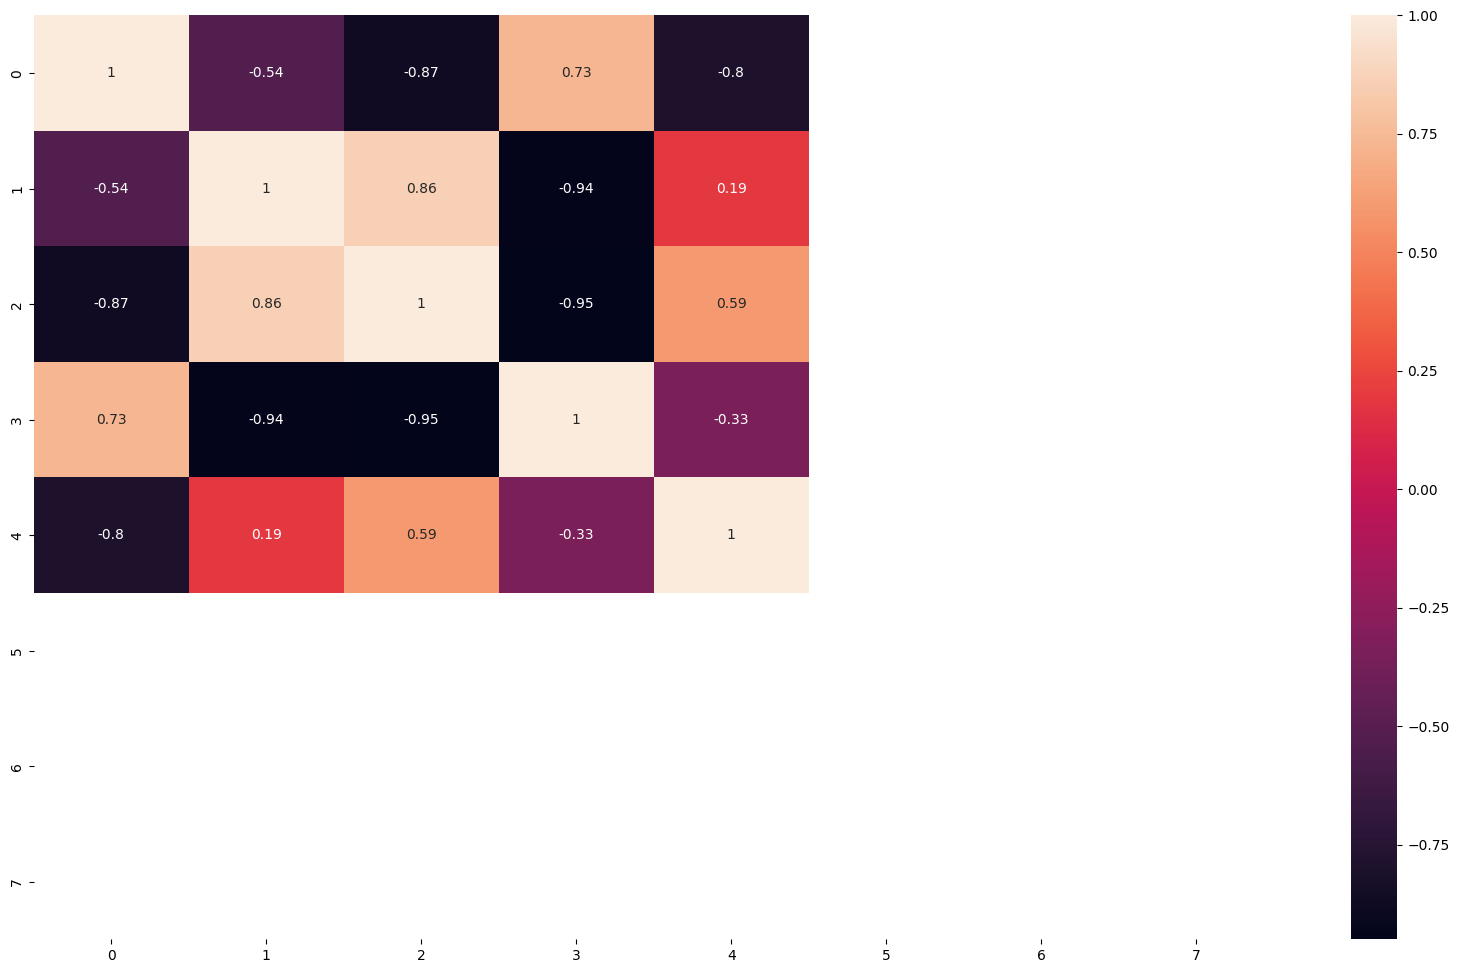

In [ ]:
import seaborn as sns
sns.heatmap(data=df_codif.corr(), annot=True)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()
# Efectivamente algunas son cero, por lo tanto, la reducción real de dimensionalidad es de 140 a < 8
# Según el entrenamiento esto puede converger diferente, se podría optimizar la cantidad. En el peor de los casos son 8.
# Lo de la posibilidad de reducir aún más las componentes, queda en evidencia dada la fuerte correlación de alguno features.

### Guardado del modelo

Puede guardar un modelo creado con la API funcional en un solo archivo. Posteriormente, puede volver a crear el mismo modelo a partir de este archivo, incluso si ya no tiene acceso al codigo que creo el modelo.

Este archivo incluye:

* Los modelos de arquitectura
* Los valores de peso del modelo (que se aprendieron durante el entrenamiento)
* La configuración de entrenamiento del modelo (lo que pasó a 'compilar'), si corresponde
* El optimizador y su estado, si corresponde (esto le permite reiniciar el entrenamiento donde lo dejó)

**NOTA**: existen varias formas de exportar, desde únicamente la topología del modelo, hasta el modelo con todos los pesos, configuraciones y demás.

In [ ]:
# Guardar el Modelo
encoder_entrenado.save('mejor_que_PCA.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Restauración del modelo

In [ ]:
from tensorflow import keras

# Recrea exactamente el mismo modelo solo desde el archivo
mejor_que_PCA = keras.models.load_model('mejor_que_PCA.h5')

In [ ]:
mejor_que_PCA.summary()         # Puedo usarlo igual que antes

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 dense (Dense)               (None, 32)                4512      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 5176 (20.22 KB)
Trainable params: 5176 (20.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Verificación de la operación del modelo cargado (simulando su uso en la posteridad, como extractor de características por ejemplo):

In [ ]:
new_features_test = mejor_que_PCA(datos_test_s)

In [ ]:
df_codif = pd.DataFrame(new_features_test.numpy())

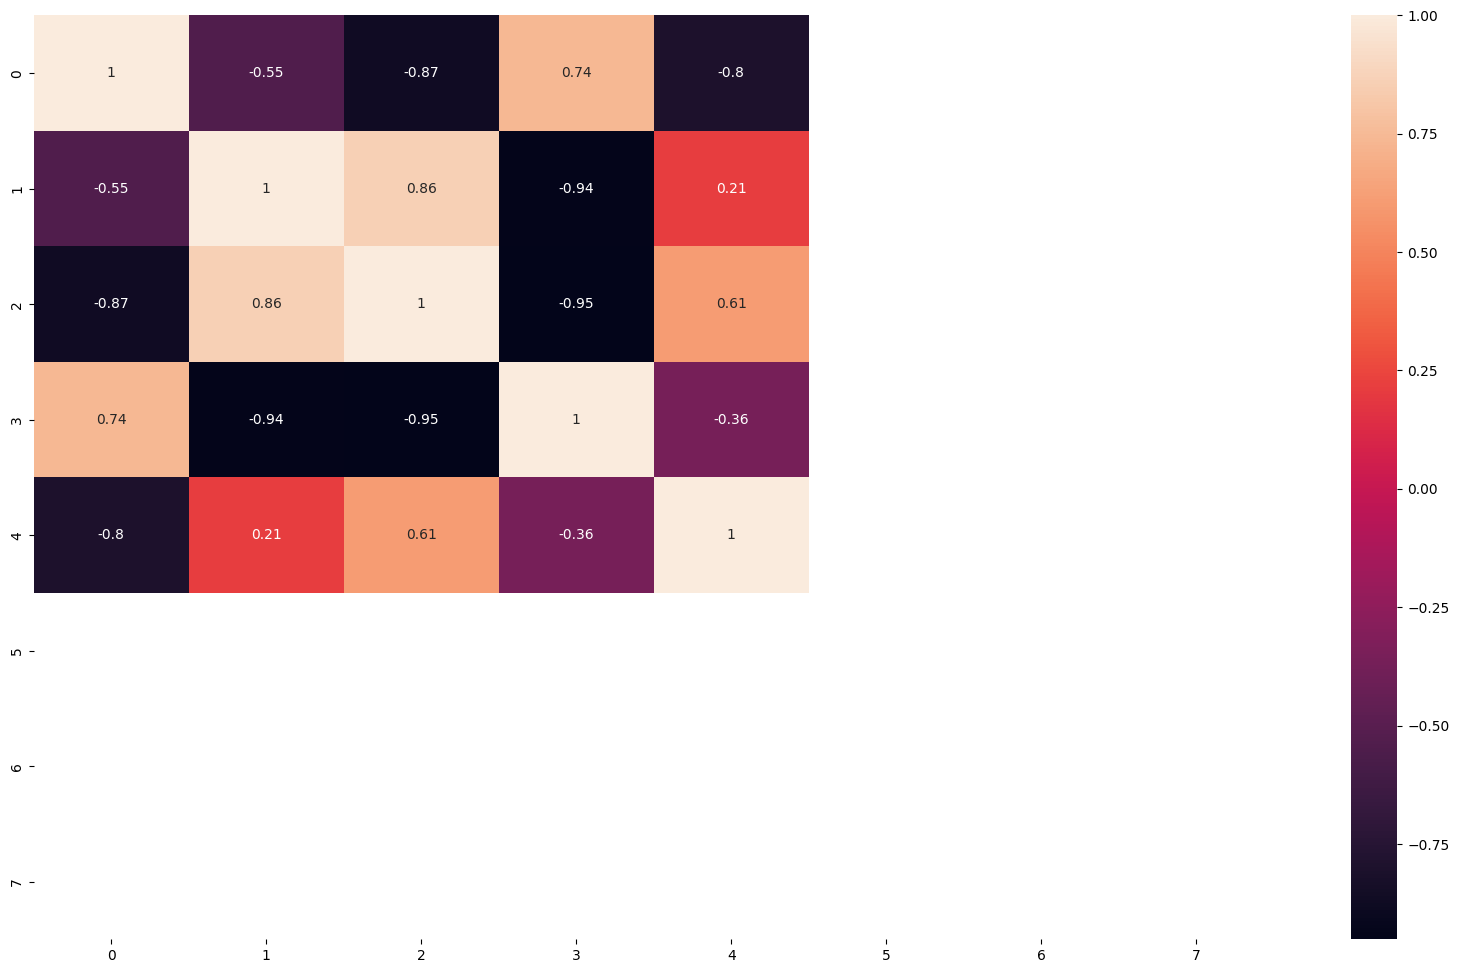

In [ ]:
sns.heatmap(data=df_codif.corr(), annot=True)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

# Referencias y Recursos



*   https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
*   https://www.tensorflow.org/tutorials/generative/autoencoder?hl=es-419
*   Ejemplo interactivo de todo esto: https://anomagram.fastforwardlabs.com/#/
*   https://www.tensorflow.org/guide/keras/save_and_serialize?hl=es-419

